# Retrieve sensor log from Raspberry Pi and graph it

In [1]:
# read raspberry pi access data from secrets file
# this version works with monthly created csv files *_yyyy-mm.csv

# Add path to my library
import sys
sys.path.append(r'/Users/alvazi2/Documents/PythonPrograms/AlvaziLib')
import Secrets
PATH = "/Users/alvazi2/Documents/JupyterLab/Secrets/"
SECRETS_FILENAME = "AlvaziSecrets.json"
secrets = Secrets.AlvaziSecrets(PATH, SECRETS_FILENAME)

In [2]:
from platform import python_version
print(python_version())

3.10.4


In [3]:
# get list of sensor log files with yyyy-mm pattern
# renamed the original big file to sensor_log_2023-00 to fit into the pattern
import glob

filePattern = 'sensor_log_*-*.csv'
csv_files = glob.glob(filePattern)
csv_files.sort(reverse=True)
csv_files = csv_files[:2]
csv_files.sort(reverse=False)
print(csv_files)

['sensor_log_2023-00.csv', 'sensor_log_2023-01.csv']


In [4]:
#get year and month
import datetime
now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")

In [5]:
from paramiko import SSHClient
from scp import SCPClient

RaspberryPi = secrets.secret("Raspberry Pi 2013")["IP"]
MyUser = secrets.secret("Raspberry Pi 2013")["USER"]
MyPassword = secrets.secret("Raspberry Pi 2013")["PASSWORD"]
RemotePath = 'Adafruit_Python_BMP/'
LogFile = 'sensor_log_{}-{}.csv'.format(year, month)

if LogFile not in csv_files:
    csv_files.append(LogFile)

# copy sensor log from my Raspberry Pi
ssh = SSHClient() #secure shell SSH connection
ssh.load_system_host_keys()
ssh.connect(RaspberryPi, username=MyUser, password=MyPassword, look_for_keys=False)
scp = SCPClient(ssh.get_transport())

for csv_file in csv_files:
    if csv_file != 'sensor_log_2023-00.csv':
        scp.get(RemotePath+csv_file)
scp.close()

In [7]:
# read sensor log file (CSV format) into pandas dataframe object
# from pandas import read_csv, to_datetime, DataFrame, Timestamp
import pandas as pd

frames = []
for csv_file in csv_files:
    print(csv_file)
    df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    frames.append(df)
sensorLog = pd.concat(frames)

# round timestamp to full minutes
sensorLog.index = pd.to_datetime(sensorLog.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M')))
# print most recent 10 sensor log entries
sensorLog.tail(10)

sensor_log_2023-00.csv
sensor_log_2023-01.csv


,Temp,Pressure,Altitude,Sealevel Pressure
TimeStamp,,,,
2023-01-21 14:15:00,13.1,102199.0,-72.76,102195.0
2023-01-21 14:30:00,13.3,102175.0,-70.53,102170.0
2023-01-21 14:45:00,13.4,102186.0,-71.52,102187.0
2023-01-21 15:00:00,13.6,102191.0,-72.51,102196.0
2023-01-21 15:15:00,13.7,102179.0,-71.77,102173.0
2023-01-21 15:30:00,13.8,102174.0,-71.44,102189.0
2023-01-21 15:45:00,14.0,102165.0,-69.29,102166.0
2023-01-21 16:00:00,14.0,102149.0,-68.79,102147.0
2023-01-21 16:15:00,14.0,102140.0,-68.05,102144.0


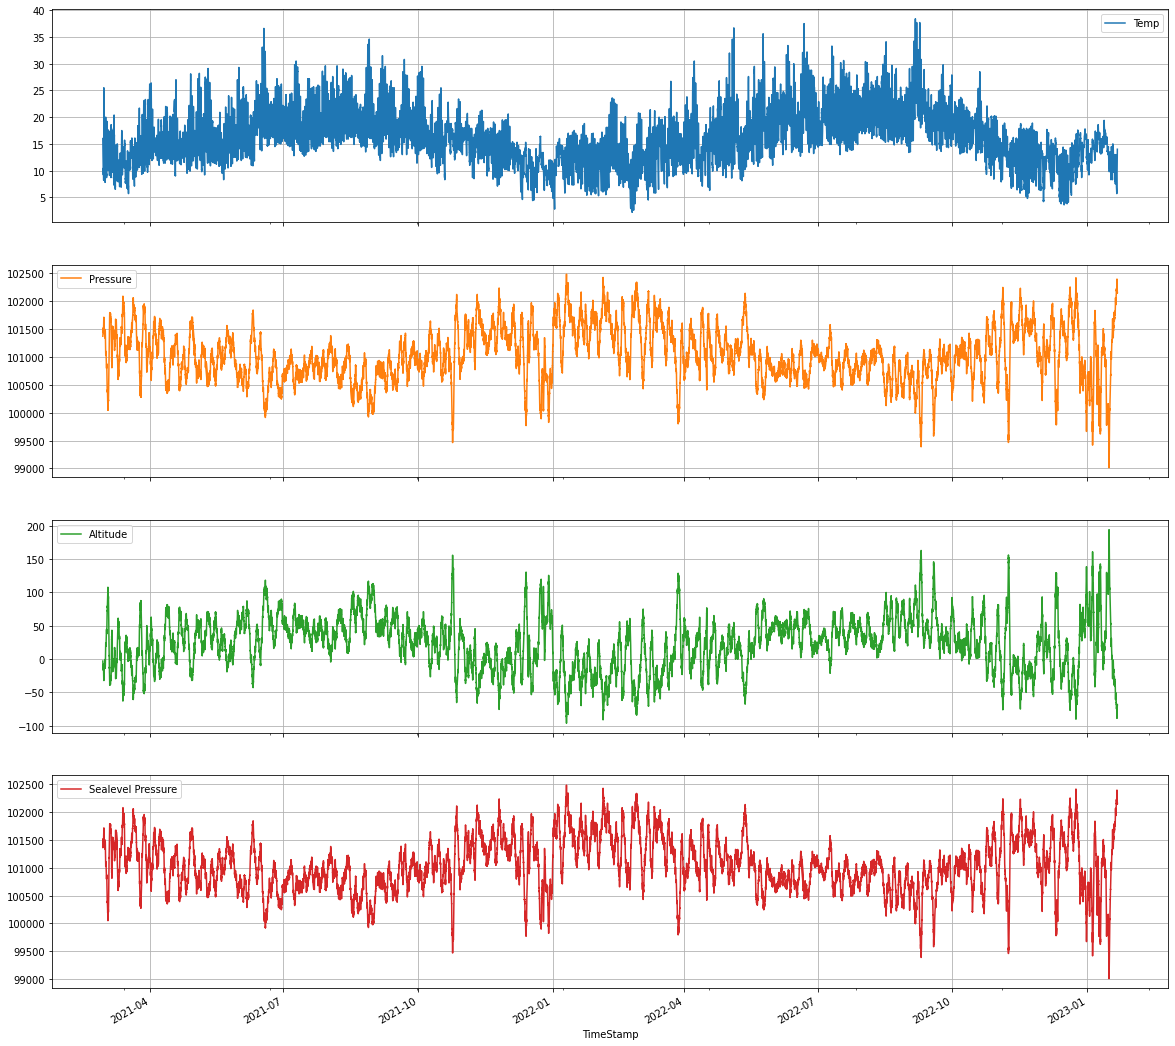

In [8]:
import matplotlib.pyplot as plt

# plot all data columns
axs = sensorLog.plot(figsize=(20,20), grid=True, subplots=True)

2023-01-21


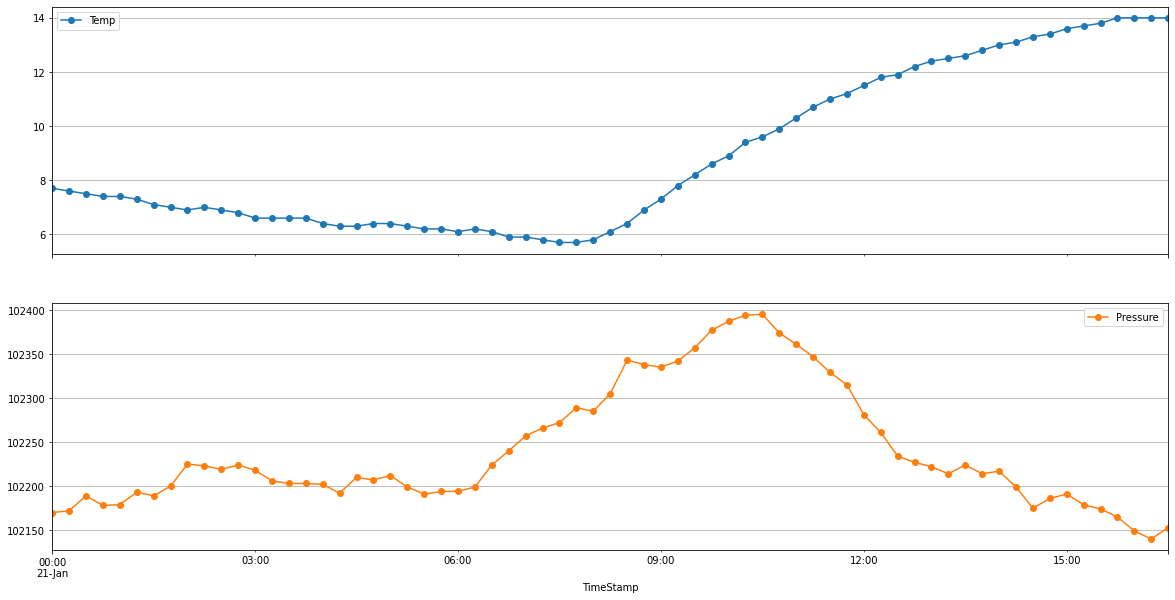

In [9]:
import datetime
today = datetime.date.today().isoformat()
print(today)
# plot today's temperature and pressure
axs = sensorLog.loc[today:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='o', subplots=True)

In [10]:
print(sensorLog.loc[today:today].describe())

            Temp       Pressure   Altitude  Sealevel Pressure
count  67.000000      67.000000  67.000000          67.000000
mean    8.904478  102240.716418 -76.161642      102243.343284
std     2.928307      68.939105   5.699710          69.031735
min     5.700000  102140.000000 -89.120000      102144.000000
25%     6.400000  102192.500000 -79.910000      102195.500000
50%     7.400000  102217.000000 -74.080000      102218.000000
75%    11.850000  102283.000000 -72.220000      102287.500000
max    14.000000  102395.000000 -68.050000      102398.000000


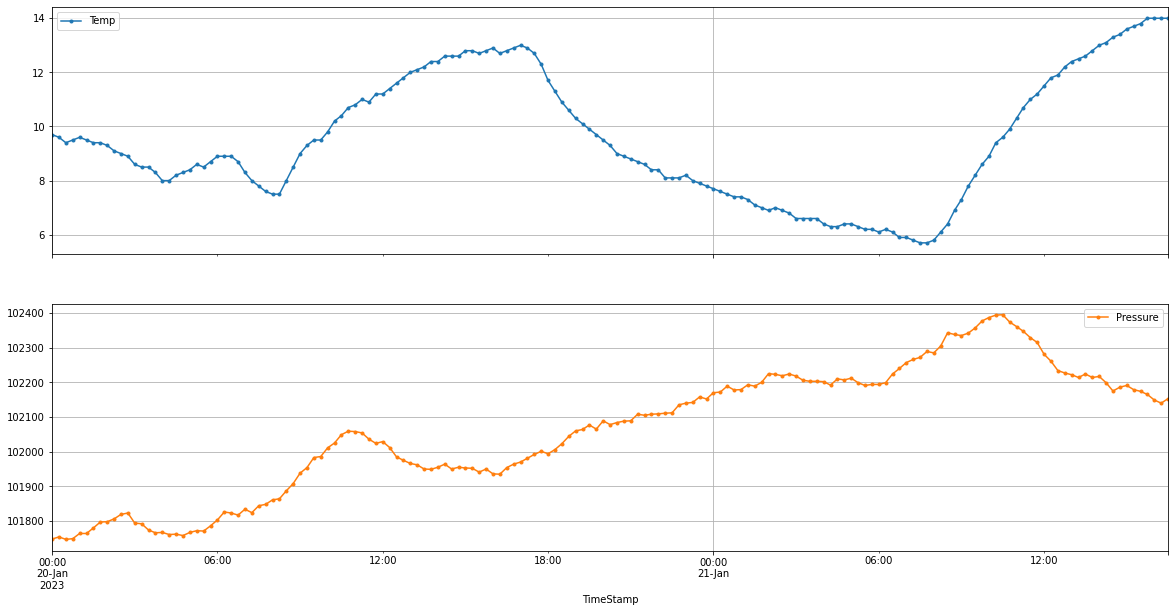

In [11]:
# plot yesterday's and today's temperature and pressure
yesterday = (datetime.date.today() - datetime.timedelta(days = 1)).isoformat()
axs = sensorLog.loc[yesterday:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, marker='.', subplots=True)

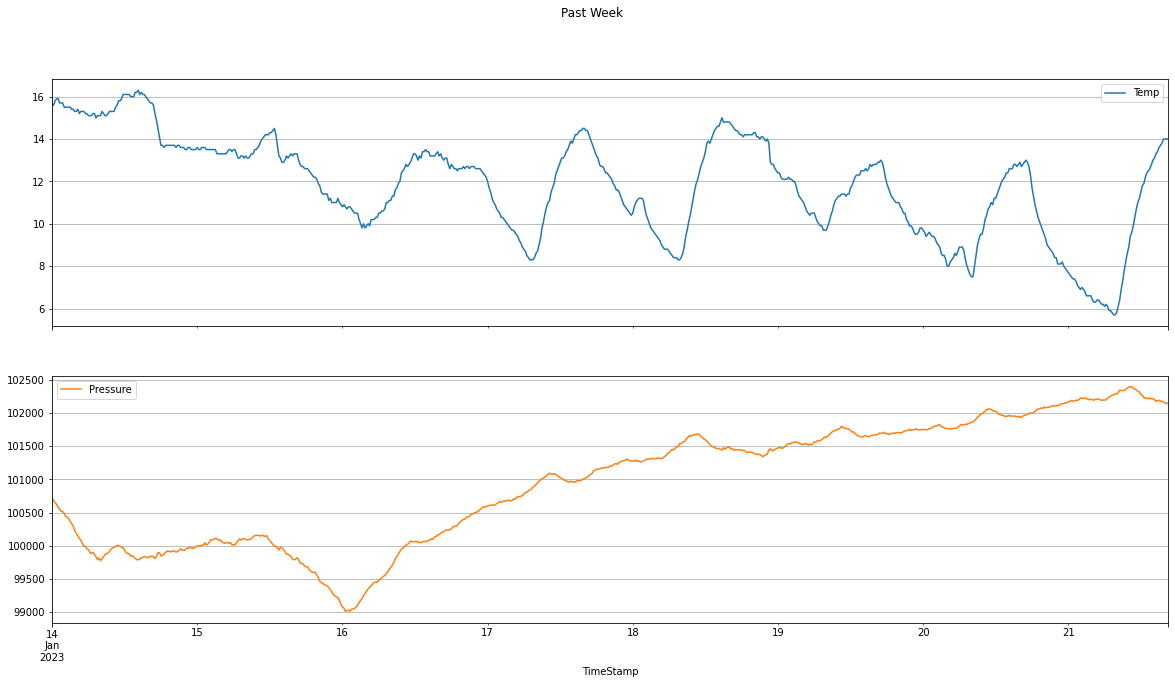

In [12]:
# plot past week's temperature and pressure
weekago = (datetime.date.today() - datetime.timedelta(weeks = 1)).isoformat() 
axs = sensorLog.loc[weekago:today].plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True, title='Past Week')
# save plot as file
plt.savefig('pastWeekPlot')

In [13]:
sensorLog.axes

[DatetimeIndex(['2021-02-27 17:03:00', '2021-02-27 17:15:00',
                '2021-02-27 17:30:00', '2021-02-27 17:45:00',
                '2021-02-27 18:00:00', '2021-02-27 18:15:00',
                '2021-02-27 18:30:00', '2021-02-27 18:45:00',
                '2021-02-27 19:00:00', '2021-02-27 19:15:00',
                ...
                '2023-01-21 14:15:00', '2023-01-21 14:30:00',
                '2023-01-21 14:45:00', '2023-01-21 15:00:00',
                '2023-01-21 15:15:00', '2023-01-21 15:30:00',
                '2023-01-21 15:45:00', '2023-01-21 16:00:00',
                '2023-01-21 16:15:00', '2023-01-21 16:30:00'],
               dtype='datetime64[ns]', name='TimeStamp', length=66505, freq=None),
 Index(['Temp', 'Pressure', 'Altitude', 'Sealevel Pressure'], dtype='object')]

In [14]:
sensorLog.loc[weekago:today].agg(['min', 'max', 'mean'])

,Temp,Pressure,Altitude,Sealevel Pressure
min,5.700000,99013.000000,-89.120000,99007.000000
max,16.300000,102395.000000,193.860000,102398.000000
mean,11.819756,100952.626522,31.190068,100954.780785


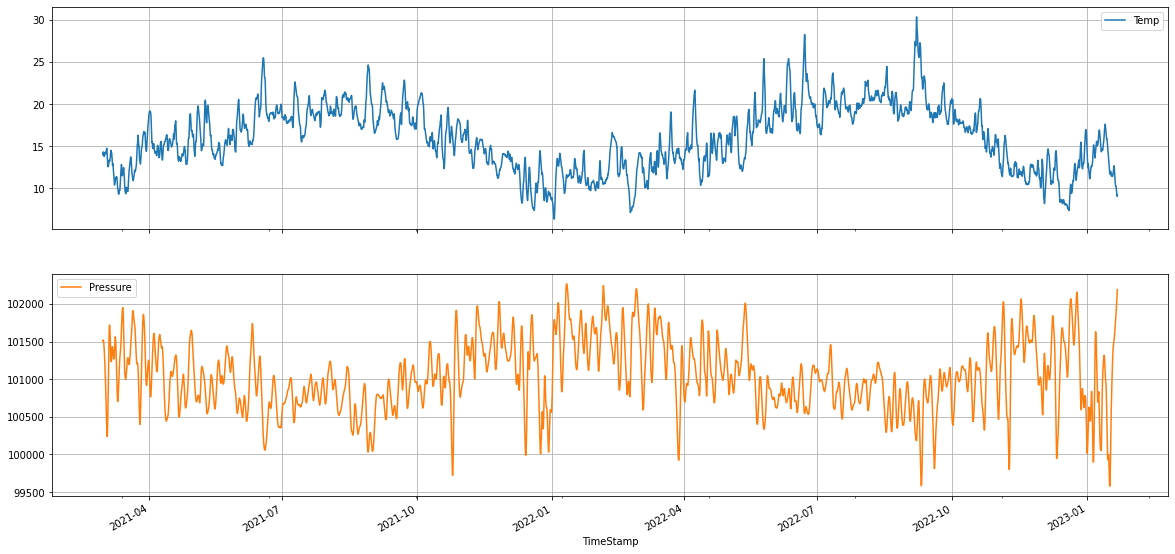

In [15]:
# 1-day rolling average
axs = sensorLog.rolling(24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

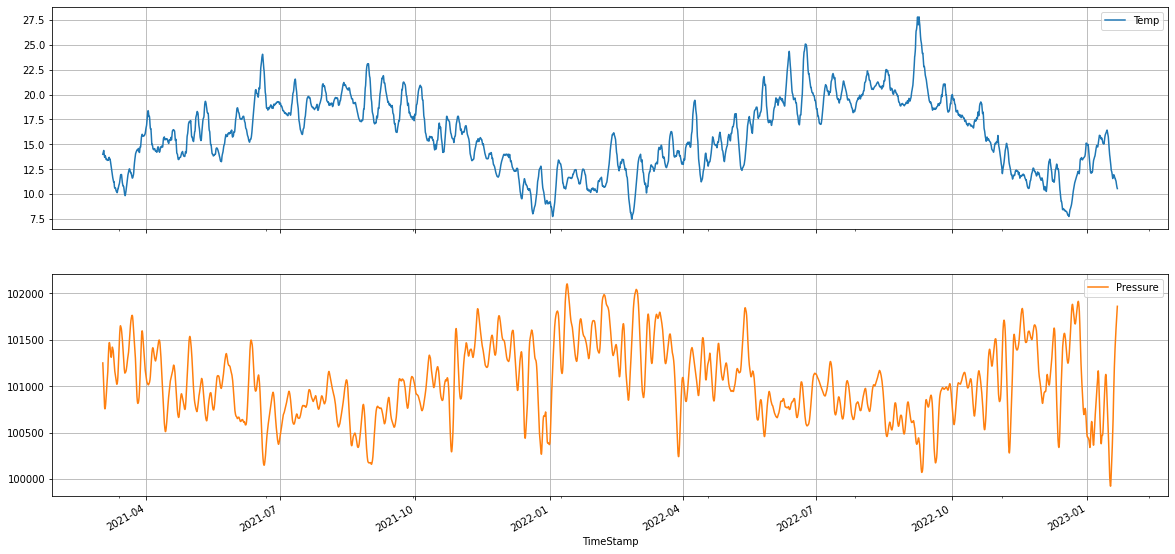

In [16]:
# 3 days rolling average
axs = sensorLog.rolling(3*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

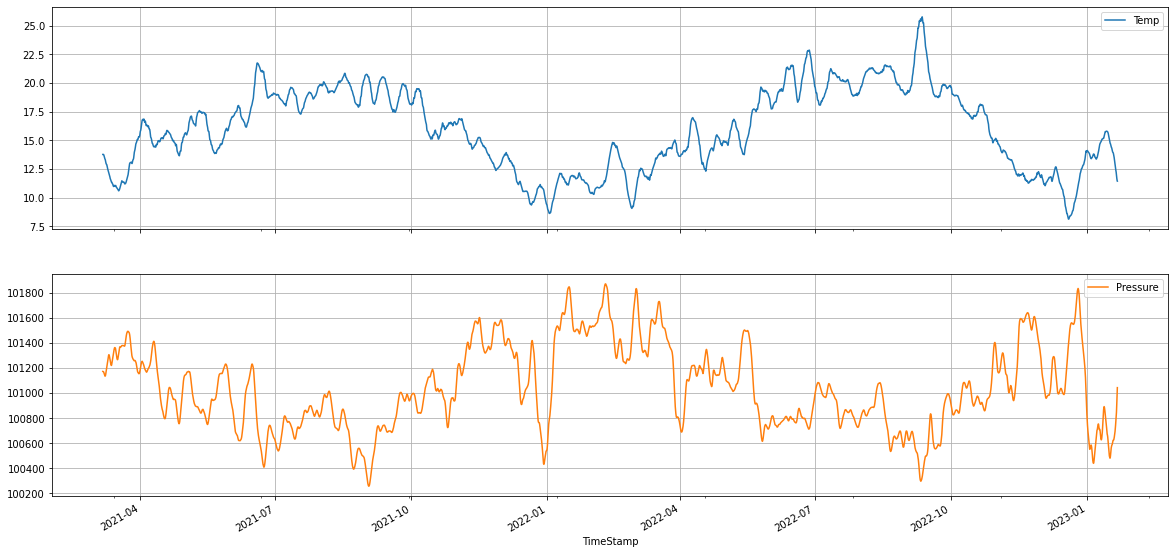

In [17]:
# 7 days rolling average
axs = sensorLog.rolling(7*24*4).mean().plot(y=['Temp','Pressure'], figsize=(20,10), grid=True, subplots=True)

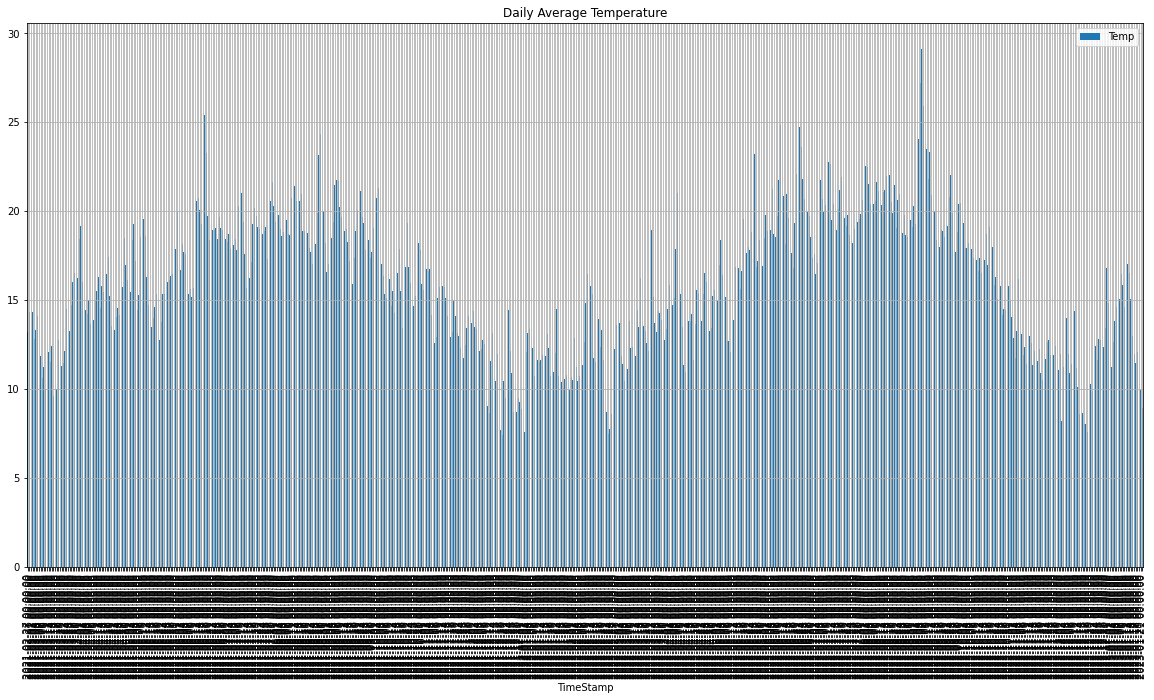

In [18]:
axs = sensorLog.resample('D', level=0).mean().plot.bar(title='Daily Average Temperature',
    y=['Temp'], figsize=(20,10), grid=True)

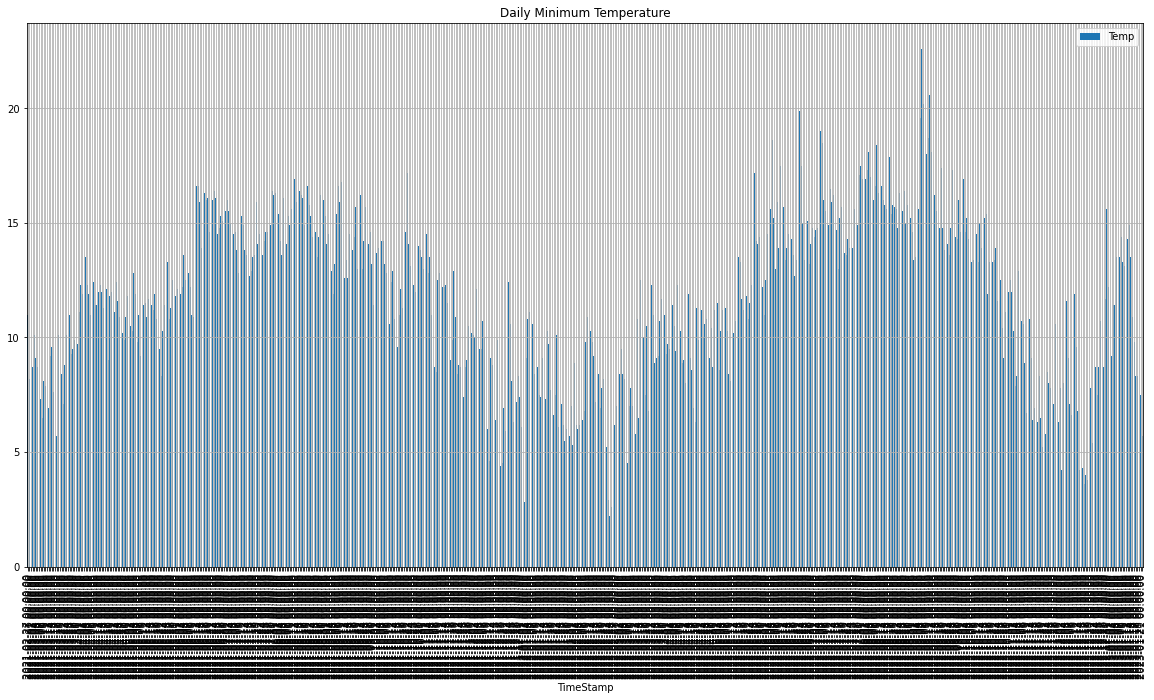

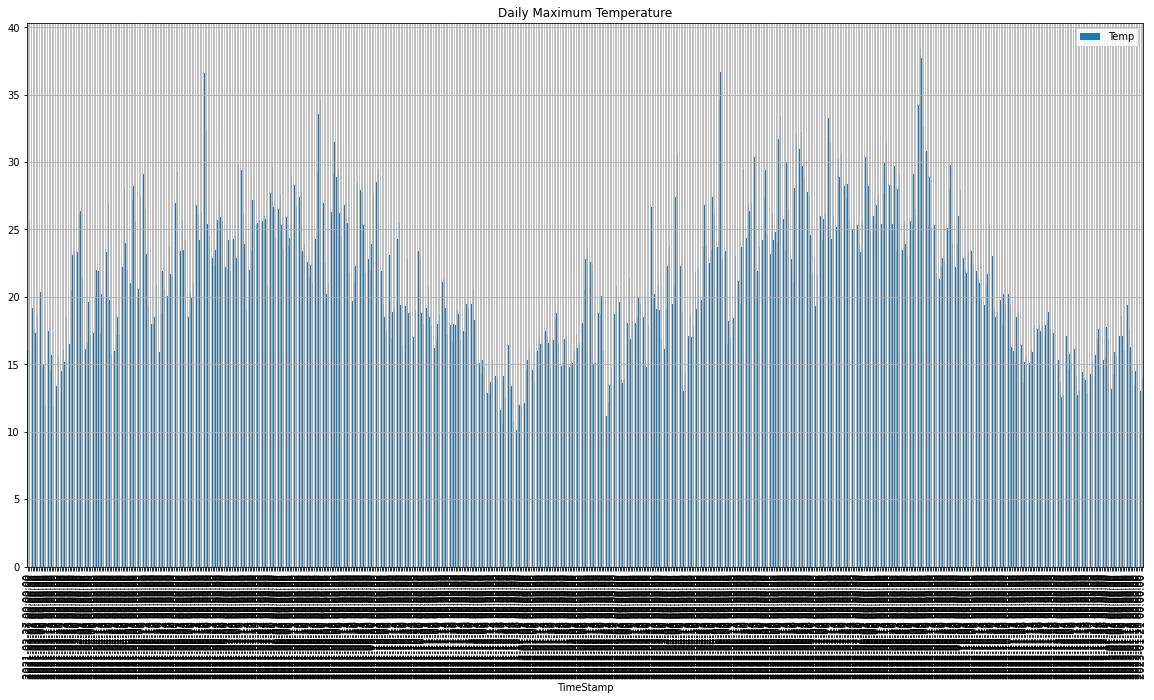

In [19]:
axs1 = sensorLog.resample('D', level=0).min().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Minimum Temperature')
axs2 = sensorLog.resample('D', level=0).max().plot.bar(
    y=['Temp'], figsize=(20,10), grid=True, title='Daily Maximum Temperature')

In [20]:
# calculate daily min, mean, max temperature using dataframe resampling
minTemp = sensorLog.loc[:yesterday].resample('D', level=0).min().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Min'})
meanTemp = sensorLog.loc[:yesterday].resample('D', level=0).mean().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Mean'})
maxTemp = sensorLog.loc[:yesterday].resample('D', level=0).max().filter(items=['TimeStamp','Temp']).rename(columns = {'Temp':'Max'})
dailyTemp = minTemp.join(meanTemp, how='outer').join(maxTemp, how='outer')

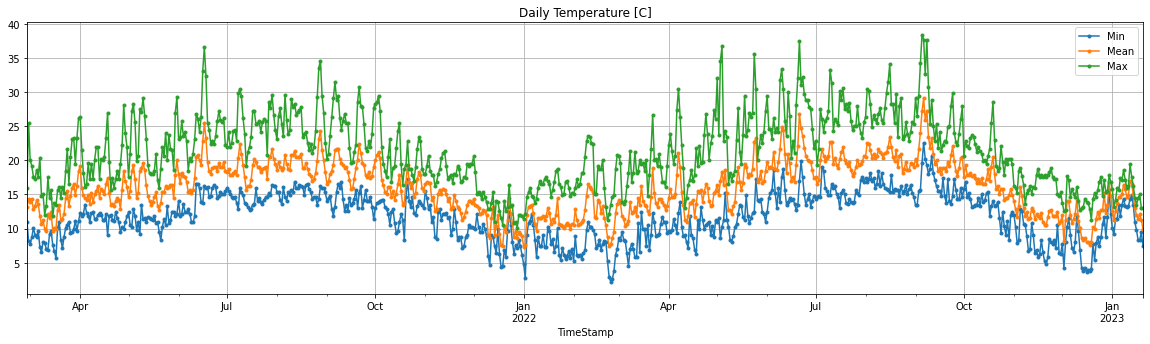

In [21]:
axs = dailyTemp.plot(figsize=(20,5), grid=True, subplots=False, marker='.', title='Daily Temperature [C]')

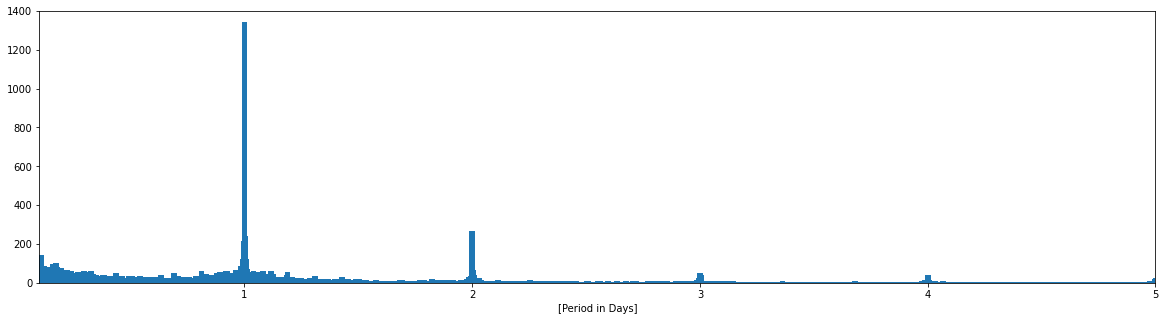

In [22]:
# fft (from https://stackoverflow.com/questions/48622933/python-performing-fft-on-csv-values-using-scipy-documentation)
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

temperatureSeries = sensorLog.filter(items=['Temp']).values.flatten() #numpy array format
dt = 15/(24*60) #time increment in unit of days (every 15 minutes)

fft = rfft(temperatureSeries)*dt
freq = rfftfreq(len(temperatureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.1,5])
plt.ylim([0,1400])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)
#axs = plt.plot(freq, abs(fft))

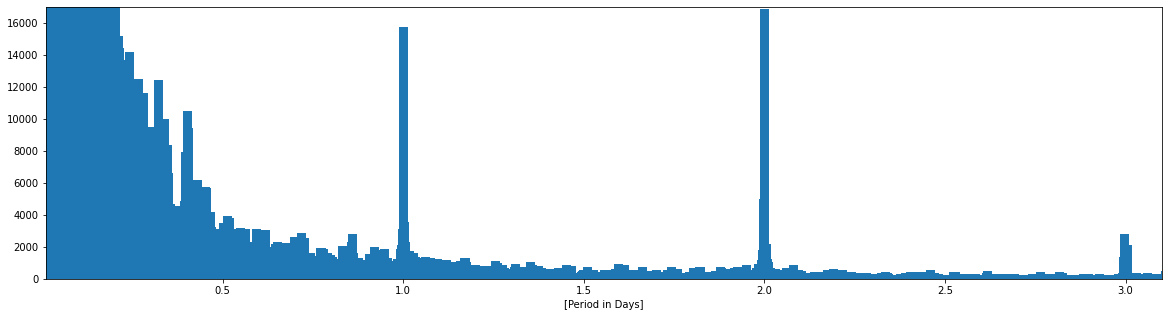

In [23]:
pressureSeries = sensorLog.filter(items=['Pressure']).values.flatten() #numpy array format

fft = rfft(pressureSeries)*dt
freq = rfftfreq(len(pressureSeries),d=dt)

plt.figure(figsize=(20,5))
plt.xlim([0.01, 3.1])
plt.ylim([0, 17000])
plt.xlabel('[Period in Days]')
axs = plt.bar(freq, abs(fft), width=0.025)

In [24]:
freq

array([0.00000000e+00, 1.44350049e-03, 2.88700098e-03, ...,
       4.79963912e+01, 4.79978347e+01, 4.79992782e+01])

In [25]:
#https://www.geeksforgeeks.org/get-the-index-of-maximum-value-in-dataframe-column/
print(sensorLog[['Temp']].idxmin(), sensorLog[['Temp']].idxmax())

Temp   2022-02-24 06:30:00
dtype: datetime64[ns] Temp   2022-09-05 17:00:00
dtype: datetime64[ns]


In [26]:
sensorLog.loc[today:today][['Temp']].idxmin()

Temp   2023-01-21 07:30:00
dtype: datetime64[ns]

In [27]:
# create dataframe with time of minimum and maximum temperature by date
# adapted from https://stackoverflow.com/questions/29569365/how-to-obtain-the-distribution-of-idmax-idmin-in-timeseries-data
sensorLogByDate = sensorLog.groupby(sensorLog.index.date)
timeMinMaxTemp = pd.DataFrame({'MinTemp_Time': sensorLogByDate['Temp'].idxmin().dt.time, 
                            'MaxTemp_Time': sensorLogByDate['Temp'].idxmax().dt.time})

In [28]:
timeMinMaxTemp.tail(10)

,MinTemp_Time,MaxTemp_Time
2023-01-12,08:00:00,15:15:00
2023-01-13,10:30:00,00:00:00
2023-01-14,22:00:00,14:15:00
2023-01-15,23:45:00,12:45:00
2023-01-16,03:15:00,13:45:00
2023-01-17,07:00:00,15:45:00
2023-01-18,07:30:00,14:45:00
2023-01-19,22:45:00,17:00:00
2023-01-20,08:00:00,17:00:00
2023-01-21,07:30:00,15:45:00


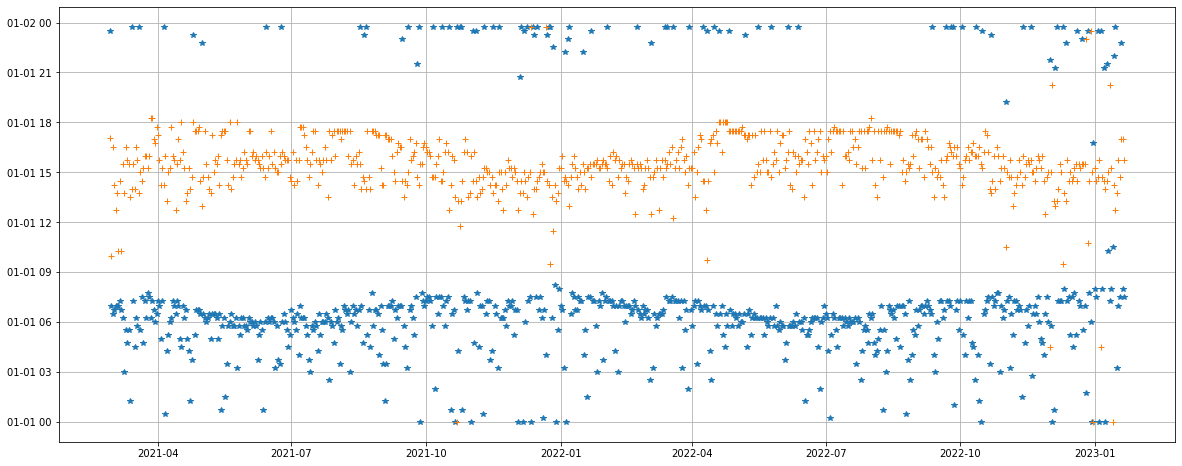

In [30]:
# plot the min/max temp times by date
minTemp_Time = pd.to_datetime(timeMinMaxTemp.MinTemp_Time, format='%H:%M:%S') #.dt.time
maxTemp_Time = pd.to_datetime(timeMinMaxTemp.MaxTemp_Time, format='%H:%M:%S') #.dt.time
plt.figure(figsize=(20,8))
plt.plot(timeMinMaxTemp.index, minTemp_Time, marker='*', linestyle='None')
plt.plot(timeMinMaxTemp.index, maxTemp_Time, marker='+', linestyle='None')
plt.grid()

https://stackoverflow.com/questions/58263983/how-to-plot-date-in-x-axis-time-in-y-axis-with-pandas-matplotlib-and-present-ti

(add also sunrise sunset times)

In [31]:
minTemp_Time

2021-02-27   1900-01-01 23:30:00
2021-02-28   1900-01-01 07:00:00
2021-03-01   1900-01-01 06:30:00
2021-03-02   1900-01-01 06:45:00
2021-03-03   1900-01-01 07:00:00
                     ...        
2023-01-17   1900-01-01 07:00:00
2023-01-18   1900-01-01 07:30:00
2023-01-19   1900-01-01 22:45:00
2023-01-20   1900-01-01 08:00:00
2023-01-21   1900-01-01 07:30:00
Name: MinTemp_Time, Length: 694, dtype: datetime64[ns]

In [32]:
sensorLog.tail(50)

,Temp,Pressure,Altitude,Sealevel Pressure
TimeStamp,,,,
2023-01-21 04:15:00,6.3,102192.0,-72.26,102199.0
2023-01-21 04:30:00,6.3,102210.0,-73.34,102208.0
2023-01-21 04:45:00,6.4,102207.0,-72.76,102210.0
2023-01-21 05:00:00,6.4,102212.0,-73.59,102214.0
2023-01-21 05:15:00,6.3,102199.0,-72.26,102209.0
2023-01-21 05:30:00,6.2,102191.0,-72.02,102197.0
2023-01-21 05:45:00,6.2,102194.0,-72.35,102203.0
2023-01-21 06:00:00,6.1,102194.0,-71.85,102195.0
2023-01-21 06:15:00,6.2,102199.0,-73.26,102201.0
